In [ ]:
### intro
# assuming you have conducted the sc_qc steps, you should have an adata object of scRNAseq data that
# has been filtered to remove duplets, background mRNA, and dead/dying cells. Now we begin the 
# process of normalization to counteract the potential variable sampling errors introduced in the
# exp. The major motivation is to ensure that insuing statatistical tests are valid.

In [ ]:
# normalization will be conducted with 3 methods
# shifted logarithm: beneficial for stabilizing variance for dimensionality reduction and DE detection
# Scran: batch correction tasks
# pearson residuals: selecting biologically variable genes (rather than technique induced noise) and 
# rare cell detection

In [1]:
### Imports
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse, csr_matrix

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

/var/folders/01/vfjvpm8d56v305x78drk6tcc0000gp/T/ipykernel_38444/3900456581.py:23: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [ ]:
### setting settings
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
# read in the processed adata object from previous workbook
adata = sc.read(filename="s4d8_quality_control.h5ad")

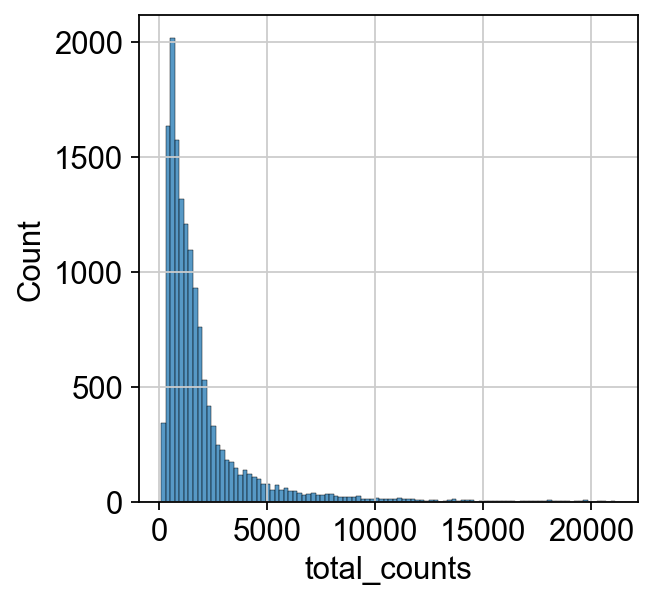

In [5]:
# for comparison purposes plot total counts
p1 = sns.histplot(adata.obs["total_counts"], bins=100)

In [6]:
### shifted Logarithm
# this is a fast method that works by applying a logartihmic function to the counts data. beneficial
# benefical for uncovering underlying data shape when paired with PCA. can be conducted using the 
# built in pp.normalized_total function

In [7]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

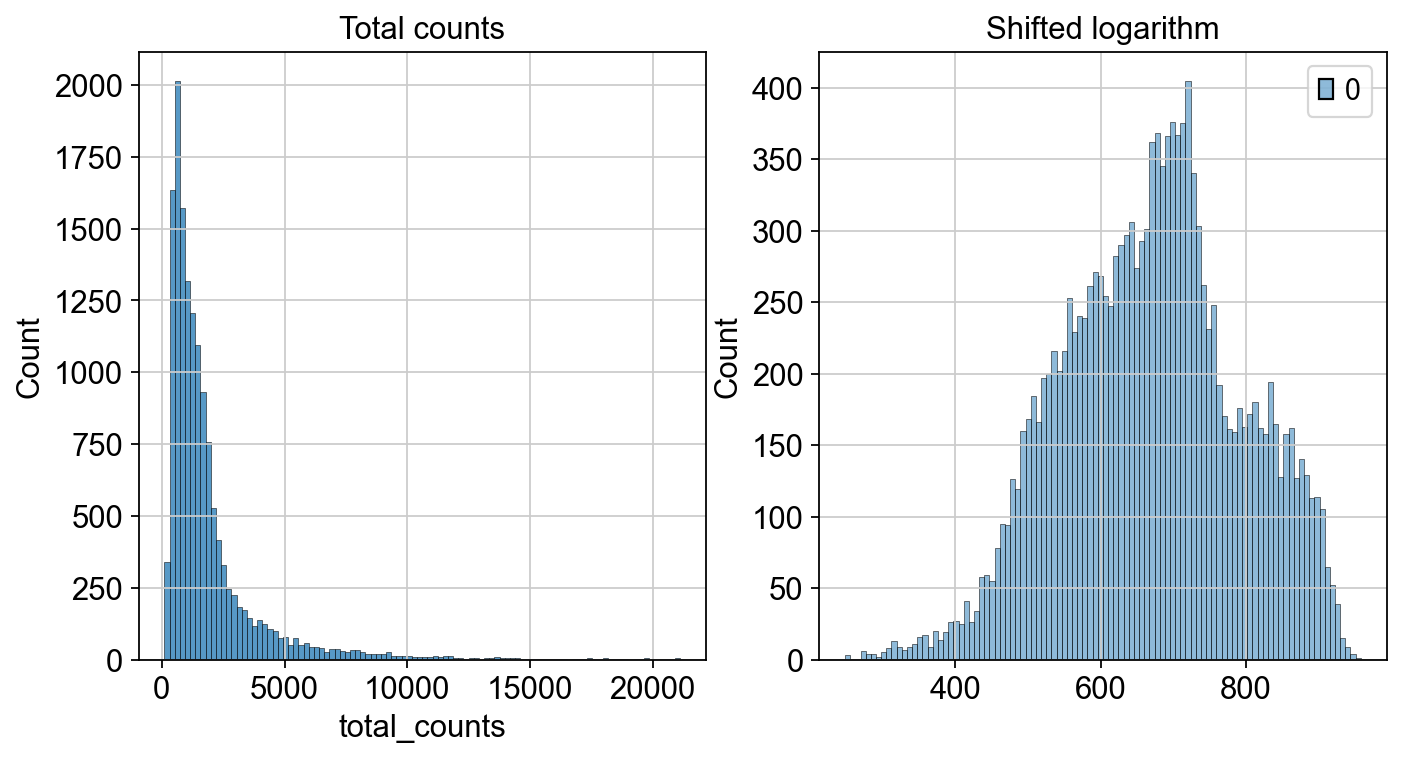

In [8]:
# visualize normalization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [9]:
### Scran
# very similar to shifted log, but adds in a deconvolution step to estimate the size factors
# used in normalization. this is done using a logistic regression over genes for cell groups and aims
# to account for difference in count depths across all cells in the dataset

In [10]:
%%R
library(scran)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [11]:
# scran requires basic clustering information (to build cell groups) so need to calc. clustering
# info prior to running
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [12]:
data_mat = adata_pp.X.T
# convert to Compressec Sparse columns (CSC) if possible. to avoid potential errors in underlying c++
# code
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [14]:
# compute the soze factors used for normalization based on cell groups

In [15]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [16]:
# now that we have calculated the size factors use them to normalize
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

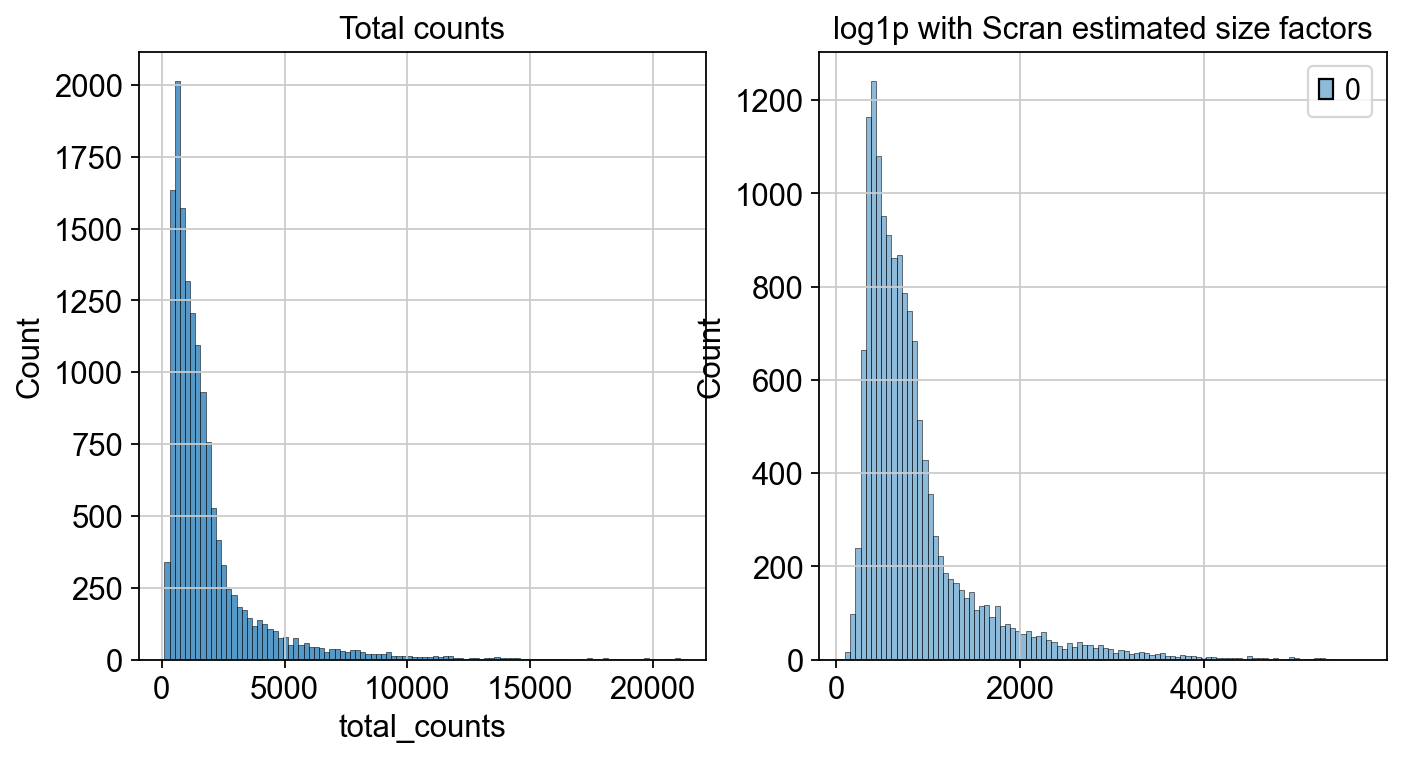

In [17]:
# compare normalization techniques
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [ ]:
### Pearson resiudals
# motivated by the expectation that cell to cell variation is due to a combination of biological 
# heterogeneity (noisey gene expression) as well as effects from techniques applied. Using negative
# binomial regression to determine a model of the technical noise in the data. 
# notably, pearson residuals do not require downstream heuristics like pseudo-count addition or
# log-transformation

In [18]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

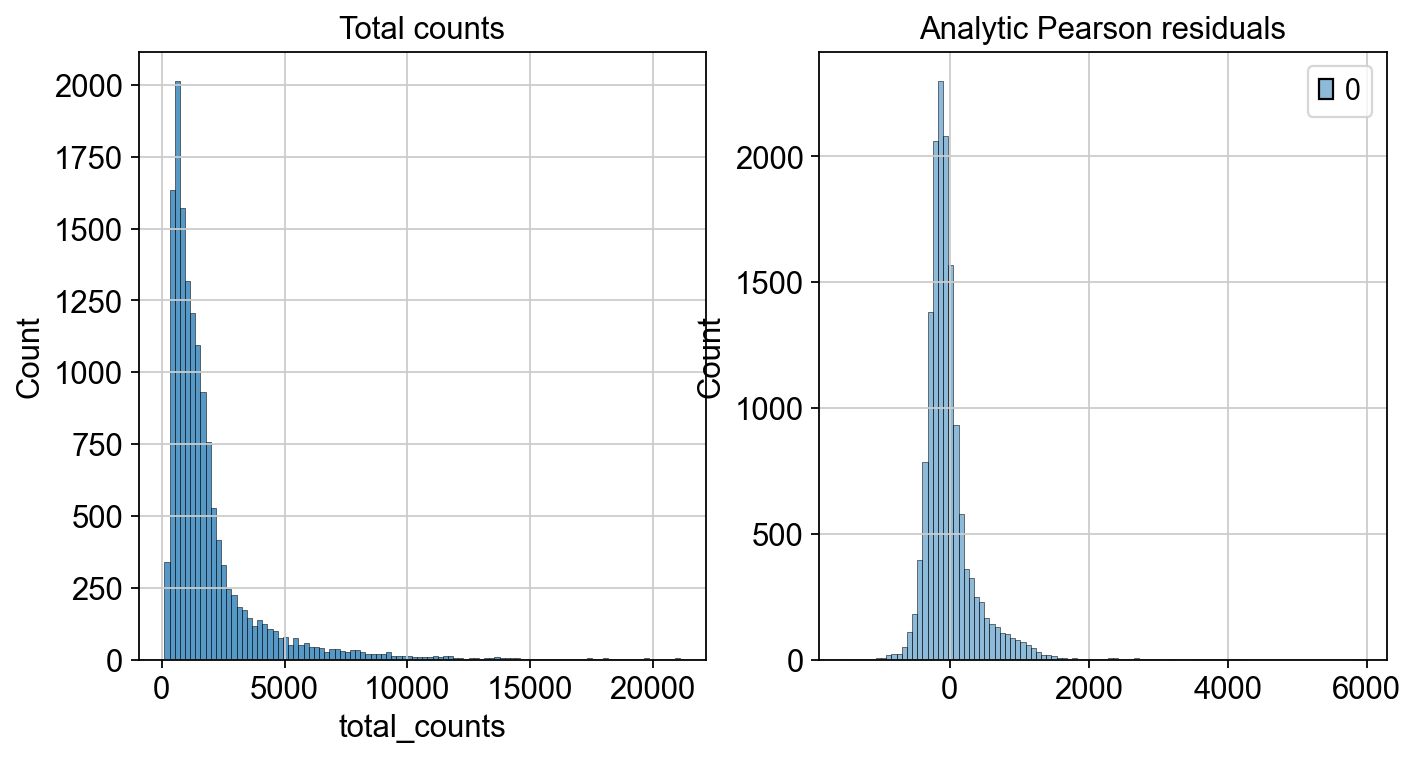

In [19]:
# visualize effects of the transformation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

Text(0.5, 1.0, 'Analytic Pearson Residuals')

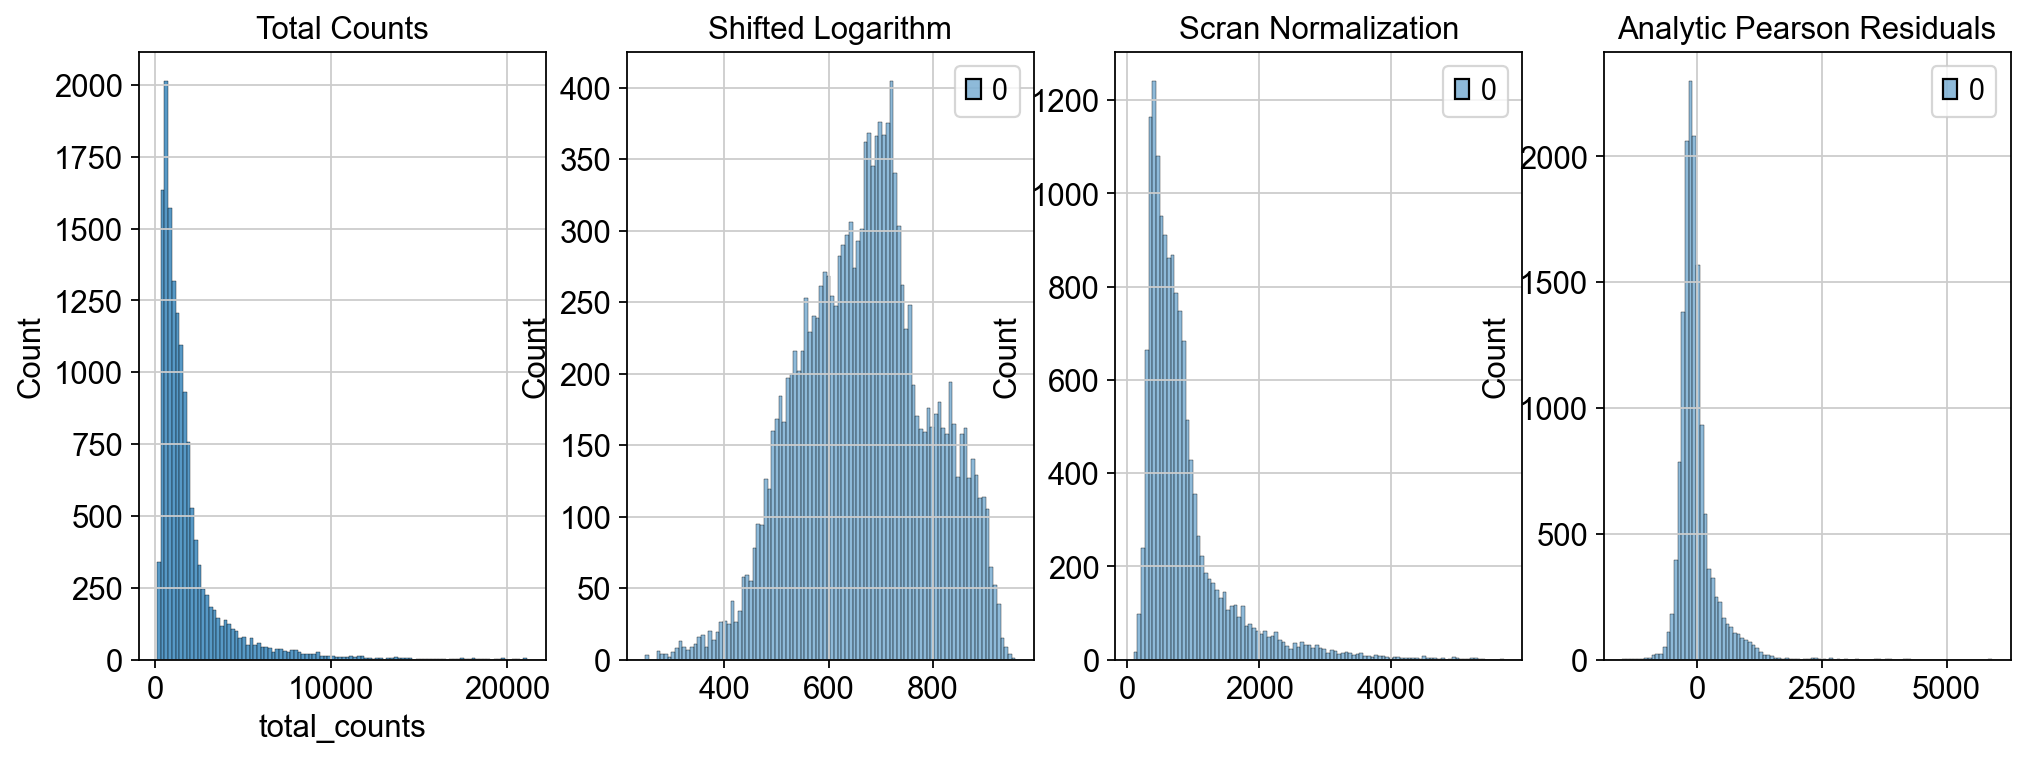

In [25]:
# visualize all three normalizations
fig, axes = plt.subplots(1,4, figsize=(15,5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total Counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted Logarithm")
p3 = sns.histplot(adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[2])
axes[2].set_title("Scran Normalization")
p4 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[3]
)
axes[3].set_title("Analytic Pearson Residuals")

In [23]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 14814 × 20178
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts', 'soupX_counts', 'log1p_norm', 'scran_normalization', 'analytic_pearson_residuals'>